In [11]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2D

In [12]:
# 生成器作成
def generator_model():
    model = Sequential()
    model.add(Dense(input_dim=100, output_dim=1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(128*7*7))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Reshape((7, 7, 128), input_shape=(128*7*7,)))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(1, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    return model

In [13]:
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Flatten, Dropout

In [14]:
# 識別器
def discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5),
                            strides=(2, 2),
                            padding='same',
                            input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, (5, 5), subsample=(2, 2)))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

In [15]:
import math
import numpy as np

In [16]:
#入力：(32, 28, 28, 1)の画像　
#出力:(196, 140)の32枚を組み合わせた画像
def combine_images(generated_images):
    total = generated_images.shape[0]
    cols = int(math.sqrt(total))
    rows = math.ceil(float(total)/cols)
    width, height = generated_images.shape[1:3]
    combined_image = np.zeros((height*rows, width*cols),
                              dtype=generated_images.dtype)

    for index, image in enumerate(generated_images):
        i = int(index/cols)
        j = index % cols
        combined_image[width*i:width*(i+1), height*j:height*(j+1)] = image.reshape(28,28)
    return combined_image

In [17]:
# combine_imagesの改良版
# 1枚ずつ画像を保存
def combine_images2(generated_images):
    width, height = generated_images.shape[1:3]
    combined_image = np.zeros((height, width),
                              dtype=generated_images.dtype)
    
    combined_image = generated_images[0].reshape(28,28)
    return combined_image

In [18]:
import os
from keras.datasets import mnist
from keras.optimizers import Adam
from PIL import Image

In [19]:
import os
from keras.datasets import mnist
from keras.optimizers import Adam
from PIL import Image

In [20]:
BATCH_SIZE = 32
NUM_EPOCH = 10
GENERATED_IMAGE_PATH = 'generated_images/' # 生成画像の保存先

In [21]:
# 以下モデル学習部分

# データ読み取り
(X_train, y_train), (_, _) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [22]:
y_train.shape

(60000,)

In [23]:
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train.shape

(60000, 28, 28)

In [24]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_train.shape

(60000, 28, 28, 1)

In [25]:
discriminator = discriminator_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/Users/mikio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), strides=(2, 2))`
  if __name__ == '__main__':


In [26]:
d_opt = Adam(lr=1e-5, beta_1=0.1)
discriminator.compile(loss='binary_crossentropy', optimizer=d_opt)

In [27]:
# generator+discriminator （discriminator部分の重みは固定）
discriminator.trainable = False
generator = generator_model()

/Users/mikio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=1024)`
  after removing the cwd from sys.path.


In [28]:
dcgan = Sequential([generator, discriminator])

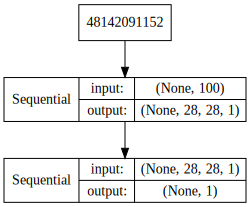

In [29]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(dcgan, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

In [30]:
g_opt = Adam(lr=2e-4, beta_1=0.5)
dcgan.compile(loss='binary_crossentropy', optimizer=g_opt)

In [31]:
num_batches = int(X_train.shape[0] / BATCH_SIZE)
print('Number of batches:', num_batches)

Number of batches: 1875


In [32]:
for epoch in range(NUM_EPOCH):
    for index in range(num_batches):
        noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
        image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
        generated_images = generator.predict(noise, verbose=0)
        
        # 生成画像を出力
        if index % 500 == 0:
            image = combine_images(generated_images)
            image = image*127.5 + 127.5
            if not os.path.exists(GENERATED_IMAGE_PATH):
                os.mkdir(GENERATED_IMAGE_PATH)
            Image.fromarray(image.astype(np.uint8))\
                    .save(GENERATED_IMAGE_PATH+"%04d_%04d.png" % (epoch, index))
        
        # discriminatorを更新
        X = np.concatenate((image_batch, generated_images))
        y = [1]*BATCH_SIZE + [0]*BATCH_SIZE
        d_loss = discriminator.train_on_batch(X, y)
        
        # generatorを更新
        noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
        g_loss = dcgan.train_on_batch(noise, [1]*BATCH_SIZE)
        print("epoch: %d, batch: %d, g_loss: %f, d_loss: %f" % (epoch, index, g_loss, d_loss))
        
    generator.save_weights('generator.h5')
    discriminator.save_weights('discriminator.h5')

Instructions for updating:
Use tf.cast instead.


/Users/mikio/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, batch: 0, g_loss: 0.715828, d_loss: 0.727600
epoch: 0, batch: 1, g_loss: 0.697859, d_loss: 0.701935
epoch: 0, batch: 2, g_loss: 0.698098, d_loss: 0.700931
epoch: 0, batch: 3, g_loss: 0.692688, d_loss: 0.696621
epoch: 0, batch: 4, g_loss: 0.676449, d_loss: 0.687975
epoch: 0, batch: 5, g_loss: 0.670267, d_loss: 0.705996
epoch: 0, batch: 6, g_loss: 0.672006, d_loss: 0.697417
epoch: 0, batch: 7, g_loss: 0.660210, d_loss: 0.710746
epoch: 0, batch: 8, g_loss: 0.658403, d_loss: 0.700746


KeyboardInterrupt: 